# 🚀 Optimized Bidirectional LSTM for Order Prediction
## Focus: BiLSTM with Client-Based Split & ≤30 Days Reordering

### Key Modifications:
- ✅ **Target Filtered**: Only predicting reorders within 30 days
- ✅ **Client-Based Split**: No client overlap between train/test sets
- ✅ **Better Generalization**: Model tested on completely unseen clients

### Expected Benefits:
1. **More focused predictions** - Model learns consistent reordering patterns
2. **Better generalization** - No data leakage from same clients
3. **Reduced variance** - Removing long-tail outliers (>30 days)
4. **Realistic evaluation** - Testing on new clients simulates production

In [1]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras -q

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


In [2]:
# Core libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import json
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Dense, Dropout, 
    BatchNormalization, Attention
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, 
    ModelCheckpoint, CSVLogger, TensorBoard
)
from tensorflow.keras.regularizers import l1_l2

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("✅ Libraries imported successfully!")
print(f"📦 TensorFlow version: {tf.__version__}")
print(f"🎲 Random seed set to: {RANDOM_SEED}")

✅ Libraries imported successfully!
📦 TensorFlow version: 2.20.0
🎲 Random seed set to: 42


## 🔧 Configuration & Model Directories

In [3]:
# Create directory structure for model management
MODEL_DIR = 'models'
CHECKPOINT_DIR = os.path.join(MODEL_DIR, 'checkpoints')
LOGS_DIR = os.path.join(MODEL_DIR, 'logs')
SCALER_DIR = os.path.join(MODEL_DIR, 'scalers')
METADATA_DIR = os.path.join(MODEL_DIR, 'metadata')

# Create directories
for directory in [MODEL_DIR, CHECKPOINT_DIR, LOGS_DIR, SCALER_DIR, METADATA_DIR]:
    os.makedirs(directory, exist_ok=True)

# Configuration
CONFIG = {
    'model_name': 'bilstm_order_prediction',
    'version': '1.0',
    'random_seed': RANDOM_SEED,
    'test_size': 0.2,
    'validation_split': 0.15,
    'batch_size': 64,
    'epochs': 150,
    'learning_rate': 0.001,
    'patience_early_stop': 20,
    'patience_reduce_lr': 10,
}

print("✅ Directory structure created:")
print(f"   📁 Models: {MODEL_DIR}")
print(f"   📁 Checkpoints: {CHECKPOINT_DIR}")
print(f"   📁 Logs: {LOGS_DIR}")
print(f"   📁 Scalers: {SCALER_DIR}")
print(f"   📁 Metadata: {METADATA_DIR}")
print(f"\n⚙️  Configuration loaded")

✅ Directory structure created:
   📁 Models: models
   📁 Checkpoints: models\checkpoints
   📁 Logs: models\logs
   📁 Scalers: models\scalers
   📁 Metadata: models\metadata

⚙️  Configuration loaded


## 🎯 Enhanced Feature Engineering
### Based on your successful implementation + additional improvements

In [4]:
def create_enhanced_features(df):
    """
    Create enhanced features optimized for BiLSTM
    Based on your successful implementation (3.59 MAE)
    """
    df = df.copy()
    
    # Convert dates
    df['sales_order_creation_date'] = pd.to_datetime(df['sales_order_creation_date'])
    df['actual_expedition_date'] = pd.to_datetime(df['actual_expedition_date'])
    
    # Sort by client and ORDER CREATION date (when client placed order)
    # This is crucial - we predict when they'll PLACE next order, not when it delivers
    df = df.sort_values(['client_name', 'sales_order_creation_date'])
    
    print("Creating features...")
    
    # ========================================================================
    # 1. CORE TEMPORAL FEATURES (Most Important)
    # ========================================================================
    
    # Days since last order
    df['days_since_last_order'] = df.groupby('client_name')['sales_order_creation_date'].diff().dt.days
    
    # Historical statistics
    df['days_since_last_order_mean'] = df.groupby('client_name')['days_since_last_order'].transform(
        lambda x: x.expanding().mean()
    )
    df['days_since_last_order_std'] = df.groupby('client_name')['days_since_last_order'].transform(
        lambda x: x.expanding().std()
    )
    df['days_since_last_order_min'] = df.groupby('client_name')['days_since_last_order'].transform(
        lambda x: x.expanding().min()
    )
    df['days_since_last_order_max'] = df.groupby('client_name')['days_since_last_order'].transform(
        lambda x: x.expanding().max()
    )
    
    # ========================================================================
    # 2. CLIENT BEHAVIOR METRICS
    # ========================================================================z
    
    # Order sequence and frequency
    df['order_sequence'] = df.groupby('client_name').cumcount() + 1
    # Use ORDER CREATION dates for client lifetime (reordering timeline)
    df['client_lifetime_days'] = df.groupby('client_name')['sales_order_creation_date'].transform(
        lambda x: (x - x.min()).dt.days
    )
    df['order_frequency_per_month'] = (df['order_sequence'] / (df['client_lifetime_days'] / 30)).replace(
        [np.inf, -np.inf], 0
    )
    
    # Order counts
    df['total_amount_delivered_tm_count'] = df.groupby('client_name').cumcount() + 1
    
    # ========================================================================
    # 3. ROLLING WINDOW FEATURES (Multiple Horizons)
    # ========================================================================
    
    for window in [3, 5, 7, 10]:
        # Days between orders
        df[f'rolling_avg_days_{window}'] = df.groupby('client_name')['days_since_last_order'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'rolling_std_days_{window}'] = df.groupby('client_name')['days_since_last_order'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
        
        # Quantity patterns
        df[f'rolling_avg_quantity_{window}'] = df.groupby('client_name')['total_amount_delivered_tm'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'rolling_std_quantity_{window}'] = df.groupby('client_name')['total_amount_delivered_tm'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
    
    # ========================================================================
    # 4. TREND & MOMENTUM FEATURES
    # ========================================================================
    
    # Ordering frequency trend
    df['order_frequency_trend'] = df.groupby('client_name')['order_frequency_per_month'].transform(
        lambda x: x.diff()
    )
    
    # Days since last order trend
    df['days_trend'] = df.groupby('client_name')['days_since_last_order'].transform(
        lambda x: x.diff()
    )
    
    # Quantity trend
    df['quantity_trend'] = df.groupby('client_name')['total_amount_delivered_tm'].transform(
        lambda x: x.diff()
    )
    
    # Recent vs historical comparison
    df['recent_vs_historical_frequency'] = df['rolling_avg_days_3'] / (df['days_since_last_order_mean'] + 1)
    
    # ========================================================================
    # 5. CLIENT MATURITY & CONSISTENCY
    # ========================================================================
    
    # Maturity level
    df['client_maturity'] = pd.cut(
        df['total_amount_delivered_tm_count'],
        bins=[0, 5, 20, np.inf],
        labels=[0, 1, 2]  # 0=new, 1=established, 2=veteran
    ).astype(int)
    
    # Consistency score (inverse of coefficient of variation)
    df['ordering_consistency'] = df['days_since_last_order_mean'] / (df['days_since_last_order_std'] + 1)
    
    # High frequency flag
    df['is_high_frequency'] = (df['order_frequency_per_month'] > df['order_frequency_per_month'].median()).astype(int)
    
    # ========================================================================
    # 6. QUANTITY FEATURES
    # ========================================================================
    
    df['total_amount_delivered_tm_mean'] = df.groupby('client_name')['total_amount_delivered_tm'].transform(
        lambda x: x.expanding().mean()
    )
    df['total_amount_delivered_tm_std'] = df.groupby('client_name')['total_amount_delivered_tm'].transform(
        lambda x: x.expanding().std()
    )
    
    # ========================================================================
    # 7. MINIMAL TEMPORAL CONTEXT (Lower priority but keep for context)
    # ========================================================================
    # Use ORDER CREATION dates (when client placed order, not delivery date)
    df['order_month'] = df['sales_order_creation_date'].dt.month
    df['order_quarter'] = df['sales_order_creation_date'].dt.quarter
    df['order_day_of_month'] = df['sales_order_creation_date'].dt.day
    
    # ========================================================================
    # 8. TARGET VARIABLE
    # ========================================================================
    
    df['days_until_next_order'] = df.groupby('client_name')['days_since_last_order'].shift(-1)
    
    # Fill missing values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)
    
    print(f"✅ Feature engineering complete!")
    print(f"   Total features created: {len(numeric_cols)}")
    
    return df

print("✅ Feature engineering function defined")

✅ Feature engineering function defined


## 🎯 Intelligent Feature Selection

In [5]:
def select_best_features():
    """
    Select features optimized for BiLSTM based on importance analysis
    """
    
    # HIGH PRIORITY - Core temporal features
    core_features = [
        'days_since_last_order',
        'days_since_last_order_mean',
        'days_since_last_order_std',
        'days_since_last_order_min',
        'days_since_last_order_max',
    ]
    
    # HIGH PRIORITY - Client behavior
    behavior_features = [
        'order_frequency_per_month',
        'total_amount_delivered_tm_count',
        'order_sequence',
        'client_lifetime_days',
    ]
    
    # MEDIUM PRIORITY - Rolling windows (multiple horizons)
    rolling_features = []
    for window in [3, 5, 7, 10]:
        rolling_features.extend([
            f'rolling_avg_days_{window}',
            f'rolling_std_days_{window}',
            f'rolling_avg_quantity_{window}',
            f'rolling_std_quantity_{window}',
        ])
    
    # MEDIUM PRIORITY - Trends
    trend_features = [
        'order_frequency_trend',
        'days_trend',
        'quantity_trend',
        'recent_vs_historical_frequency',
    ]
    
    # LOW PRIORITY - Consistency & maturity
    meta_features = [
        'client_maturity',
        'ordering_consistency',
        'is_high_frequency',
    ]
    
    # LOW PRIORITY - Quantity
    quantity_features = [
        'total_amount_delivered_tm',
        'total_amount_delivered_tm_mean',
        'total_amount_delivered_tm_std',
    ]
    
    # MINIMAL - Temporal context
    temporal_features = [
        'order_month',
        'order_quarter',
        'order_day_of_month',
    ]
    
    # Combine all
    selected_features = (
        core_features + 
        behavior_features + 
        rolling_features + 
        trend_features + 
        meta_features + 
        quantity_features + 
        temporal_features
    )
    
    print(f"\n📊 Feature Selection Summary:")
    print(f"   Core Temporal: {len(core_features)}")
    print(f"   Behavior: {len(behavior_features)}")
    print(f"   Rolling Windows: {len(rolling_features)}")
    print(f"   Trends: {len(trend_features)}")
    print(f"   Meta: {len(meta_features)}")
    print(f"   Quantity: {len(quantity_features)}")
    print(f"   Temporal: {len(temporal_features)}")
    print(f"   " + "="*50)
    print(f"   Total Selected: {len(selected_features)}")
    
    return selected_features

print("✅ Feature selection function defined")

✅ Feature selection function defined


## 🔧 Data Preparation with Model Persistence

In [6]:
def prepare_data_for_lstm(df, selected_features, config):
    """
    Prepare data for LSTM with scaler persistence
    """
    
    # Remove rows without target
    df_clean = df.dropna(subset=['days_until_next_order']).copy()
    
    # Separate features and target
    X = df_clean[selected_features].copy()
    y = df_clean['days_until_next_order'].copy()
    
    # Split data (temporal split - no shuffle)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=config['test_size'], 
        random_state=config['random_seed'],
        shuffle=False  # Preserve temporal order
    )
    
    # Scale features using RobustScaler (better for outliers)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Reshape for LSTM: (samples, timesteps, features)
    X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    
    # Save scaler
    scaler_path = os.path.join(SCALER_DIR, 'feature_scaler.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"\n💾 Scaler saved to: {scaler_path}")
    
    # Save feature names
    feature_path = os.path.join(METADATA_DIR, 'feature_names.json')
    with open(feature_path, 'w') as f:
        json.dump(selected_features, f, indent=2)
    print(f"💾 Feature names saved to: {feature_path}")
    
    print(f"\n📊 Data Preparation Summary:")
    print(f"   Training samples: {X_train_lstm.shape[0]:,}")
    print(f"   Test samples: {X_test_lstm.shape[0]:,}")
    print(f"   Number of features: {X_train_lstm.shape[2]}")
    print(f"   LSTM input shape: {X_train_lstm.shape}")
    print(f"   Target mean (train): {y_train.mean():.2f} days")
    print(f"   Target std (train): {y_train.std():.2f} days")
    
    return {
        'X_train': X_train_lstm,
        'X_test': X_test_lstm,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'feature_names': selected_features
    }

print("✅ Data preparation function defined")

✅ Data preparation function defined


## 🧠 Enhanced Bidirectional LSTM Architecture

In [7]:
def build_enhanced_bilstm(input_shape, config):
    """
    Build enhanced BiLSTM based on your successful architecture
    Optimized for 3.59 MAE performance
    """
    
    model = Sequential([
        # First Bidirectional LSTM layer with attention
        Bidirectional(
            LSTM(
                128,
                return_sequences=True,
                kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
                recurrent_dropout=0.1
            ),
            input_shape=input_shape
        ),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second Bidirectional LSTM layer
        Bidirectional(
            LSTM(
                64,
                return_sequences=False,
                kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
                recurrent_dropout=0.1
            )
        ),
        BatchNormalization(),
        Dropout(0.3),
        
        # Dense layers
        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005)),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        
        # Output layer
        Dense(1, activation='linear')
    ])
    
    # Compile with Huber loss (robust to outliers)
    optimizer = keras.optimizers.Adam(
        learning_rate=config['learning_rate'],
        clipnorm=1.0  # Gradient clipping
    )
    
    model.compile(
        optimizer=optimizer,
        loss='huber',  # Robust to outliers
        metrics=['mae', 'mse']
    )
    
    return model

print("✅ Model architecture function defined")

✅ Model architecture function defined


## 📊 Comprehensive Training Callbacks

In [8]:
def create_callbacks(config):
    """
    Create comprehensive callbacks for training
    """
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    callbacks = [
        # 1. Early Stopping
        EarlyStopping(
            monitor='val_loss',
            patience=config['patience_early_stop'],
            restore_best_weights=True,
            verbose=1,
            mode='min'
        ),
        
        # 2. Reduce Learning Rate on Plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=config['patience_reduce_lr'],
            min_lr=1e-7,
            verbose=1,
            mode='min'
        ),
        
        # 3. Model Checkpoint (save best model)
        ModelCheckpoint(
            filepath=os.path.join(CHECKPOINT_DIR, f'best_model_{timestamp}.h5'),
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=1,
            mode='min'
        ),
        
        # 4. CSV Logger (detailed training history)
        CSVLogger(
            filename=os.path.join(LOGS_DIR, f'training_log_{timestamp}.csv'),
            append=False
        ),
        
        # 5. TensorBoard (optional, for visualization)
        TensorBoard(
            log_dir=os.path.join(LOGS_DIR, f'tensorboard_{timestamp}'),
            histogram_freq=1,
            write_graph=True
        )
    ]
    
    print(f"\n📋 Callbacks configured:")
    print(f"   ✓ Early Stopping (patience={config['patience_early_stop']})")
    print(f"   ✓ Reduce LR on Plateau (patience={config['patience_reduce_lr']})")
    print(f"   ✓ Model Checkpoint")
    print(f"   ✓ CSV Logger")
    print(f"   ✓ TensorBoard")
    
    return callbacks, timestamp

print("✅ Callbacks function defined")

✅ Callbacks function defined


## 🚀 Model Training with Progress Tracking

In [9]:
def train_bilstm(model, data, config, callbacks):
    """
    Train BiLSTM model with comprehensive monitoring
    """
    
    print("\n" + "="*80)
    print("🚀 STARTING MODEL TRAINING")
    print("="*80)
    
    training_start = datetime.now()
    
    history = model.fit(
        data['X_train'], data['y_train'],
        validation_split=config['validation_split'],
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        callbacks=callbacks,
        verbose=1
    )
    
    training_duration = datetime.now() - training_start
    
    print("\n" + "="*80)
    print("✅ TRAINING COMPLETE")
    print("="*80)
    print(f"   Duration: {training_duration}")
    print(f"   Epochs completed: {len(history.history['loss'])}")
    print(f"   Best val_loss: {min(history.history['val_loss']):.4f}")
    print(f"   Best val_mae: {min(history.history['val_mae']):.4f}")
    
    return model, history

print("✅ Training function defined")

✅ Training function defined


In [10]:
# FIXED VERSION - Use this instead of the previous save_complete_model function
def save_complete_model(model, data, config, history, timestamp):
    """
    Save model in multiple formats with metadata (Keras 3 compatible)
    """
    
    print("\n" + "="*80)
    print("💾 SAVING MODEL")
    print("="*80)
    
    model_name = f"{config['model_name']}_v{config['version']}_{timestamp}"
    
    # 1. Save full model (.h5 format)
    h5_path = os.path.join(MODEL_DIR, f'{model_name}.h5')
    model.save(h5_path)
    print(f"✅ Model saved (HDF5): {h5_path}")
    
    # 2. Save model in native Keras format (Keras 3 format)
    keras_path = os.path.join(MODEL_DIR, f'{model_name}.keras')
    model.save(keras_path)
    print(f"✅ Model saved (Keras format): {keras_path}")
    
    # 3. Save model weights only
    weights_path = os.path.join(MODEL_DIR, f'{model_name}_weights.h5')
    model.save_weights(weights_path)
    print(f"✅ Weights saved: {weights_path}")
    
    # 4. Save model architecture (JSON)
    architecture_path = os.path.join(METADATA_DIR, f'{model_name}_architecture.json')
    with open(architecture_path, 'w') as f:
        f.write(model.to_json())
    print(f"✅ Architecture saved: {architecture_path}")
    
    # 5. Save training history
    history_path = os.path.join(METADATA_DIR, f'{model_name}_history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"✅ Training history saved: {history_path}")
    
    # 6. Save metadata (configuration + performance)
    metadata = {
        'model_name': model_name,
        'timestamp': timestamp,
        'config': config,
        'training_info': {
            'total_epochs': len(history.history['loss']),
            'best_val_loss': float(min(history.history['val_loss'])),
            'best_val_mae': float(min(history.history['val_mae'])),
            'final_train_loss': float(history.history['loss'][-1]),
            'final_train_mae': float(history.history['mae'][-1]),
        },
        'data_info': {
            'n_features': len(data['feature_names']),
            'n_train_samples': int(data['X_train'].shape[0]),
            'n_test_samples': int(data['X_test'].shape[0]),
            'target_mean': float(data['y_train'].mean()),
            'target_std': float(data['y_train'].std()),
        }
    }
    
    metadata_path = os.path.join(METADATA_DIR, f'{model_name}_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✅ Metadata saved: {metadata_path}")
    
    # 7. Create a "latest" symlink or copy
    latest_path = os.path.join(MODEL_DIR, 'latest_model.h5')
    import shutil
    shutil.copy2(h5_path, latest_path)
    print(f"✅ Latest model link created: {latest_path}")
    
    print("\n" + "="*80)
    print("🎉 MODEL SAVED SUCCESSFULLY")
    print("="*80)
    print(f"\n📦 Saved artifacts:")
    print(f"   1. Full model (.h5): {h5_path}")
    print(f"   2. Keras format (.keras): {keras_path}")
    print(f"   3. Weights only: {weights_path}")
    print(f"   4. Architecture (JSON): {architecture_path}")
    print(f"   5. Training history: {history_path}")
    print(f"   6. Metadata: {metadata_path}")
    print(f"   7. Latest model: {latest_path}")
    
    return model_name, metadata

print("✅ FIXED Model saving function defined - ready to use!")


✅ FIXED Model saving function defined - ready to use!


## 💾 Comprehensive Model Saving

In [11]:
def save_complete_model(model, data, config, history, timestamp):
    """
    Save model in multiple formats with metadata
    """
    
    print("\n" + "="*80)
    print("💾 SAVING MODEL")
    print("="*80)
    
    model_name = f"{config['model_name']}_v{config['version']}_{timestamp}"
    
    # 1. Save full model (.h5 format)
    h5_path = os.path.join(MODEL_DIR, f'{model_name}.h5')
    model.save(h5_path)
    print(f"✅ Model saved (HDF5): {h5_path}")
    
    # 2. Save model in SavedModel format (TensorFlow)
    savedmodel_path = os.path.join(MODEL_DIR, f'{model_name}_savedmodel')
    model.save(savedmodel_path, save_format='tf')
    print(f"✅ Model saved (SavedModel): {savedmodel_path}")
    
    # 3. Save model weights only
    weights_path = os.path.join(MODEL_DIR, f'{model_name}_weights.h5')
    model.save_weights(weights_path)
    print(f"✅ Weights saved: {weights_path}")
    
    # 4. Save model architecture (JSON)
    architecture_path = os.path.join(METADATA_DIR, f'{model_name}_architecture.json')
    with open(architecture_path, 'w') as f:
        f.write(model.to_json())
    print(f"✅ Architecture saved: {architecture_path}")
    
    # 5. Save training history
    history_path = os.path.join(METADATA_DIR, f'{model_name}_history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"✅ Training history saved: {history_path}")
    
    # 6. Save metadata (configuration + performance)
    metadata = {
        'model_name': model_name,
        'timestamp': timestamp,
        'config': config,
        'training_info': {
            'total_epochs': len(history.history['loss']),
            'best_val_loss': float(min(history.history['val_loss'])),
            'best_val_mae': float(min(history.history['val_mae'])),
            'final_train_loss': float(history.history['loss'][-1]),
            'final_train_mae': float(history.history['mae'][-1]),
        },
        'data_info': {
            'n_features': len(data['feature_names']),
            'n_train_samples': int(data['X_train'].shape[0]),
            'n_test_samples': int(data['X_test'].shape[0]),
            'target_mean': float(data['y_train'].mean()),
            'target_std': float(data['y_train'].std()),
        }
    }
    
    metadata_path = os.path.join(METADATA_DIR, f'{model_name}_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✅ Metadata saved: {metadata_path}")
    
    # 7. Create a "latest" symlink or copy
    latest_path = os.path.join(MODEL_DIR, 'latest_model.h5')
    import shutil
    shutil.copy2(h5_path, latest_path)
    print(f"✅ Latest model link created: {latest_path}")
    
    print("\n" + "="*80)
    print("🎉 MODEL SAVED SUCCESSFULLY")
    print("="*80)
    print(f"\n📦 Saved artifacts:")
    print(f"   1. Full model (.h5): {h5_path}")
    print(f"   2. SavedModel format: {savedmodel_path}")
    print(f"   3. Weights only: {weights_path}")
    print(f"   4. Architecture (JSON): {architecture_path}")
    print(f"   5. Training history: {history_path}")
    print(f"   6. Metadata: {metadata_path}")
    print(f"   7. Latest model: {latest_path}")
    
    return model_name, metadata

print("✅ Model saving function defined")

✅ Model saving function defined


## 📊 Model Evaluation & Performance Analysis

In [12]:
def evaluate_model_comprehensive(model, X_test, y_test):
    """
    Comprehensive model evaluation
    """
    
    print("\n" + "="*80)
    print("📊 MODEL EVALUATION")
    print("="*80)
    
    # Make predictions
    y_pred = model.predict(X_test, verbose=0).flatten()
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Median absolute error
    median_ae = np.median(np.abs(y_test - y_pred))
    
    # Mean Absolute Percentage Error (handle division by zero)
    mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test != 0, y_test, 1))) * 100
    
    # Prediction accuracy at different thresholds
    within_3_days = np.mean(np.abs(y_test - y_pred) <= 3) * 100
    within_7_days = np.mean(np.abs(y_test - y_pred) <= 7) * 100
    within_14_days = np.mean(np.abs(y_test - y_pred) <= 14) * 100
    within_30_days = np.mean(np.abs(y_test - y_pred) <= 30) * 100
    
    print(f"\n🎯 Core Metrics:")
    print(f"   MAE (Mean Absolute Error):      {mae:.2f} days")
    print(f"   RMSE (Root Mean Squared Error): {rmse:.2f} days")
    print(f"   R² Score:                       {r2:.4f}")
    print(f"   Median Absolute Error:          {median_ae:.2f} days")
    print(f"   MAPE:                           {mape:.2f}%")
    
    print(f"\n🎯 Prediction Accuracy:")
    print(f"   Within  3 days:  {within_3_days:5.1f}%")
    print(f"   Within  7 days:  {within_7_days:5.1f}%")
    print(f"   Within 14 days:  {within_14_days:5.1f}%")
    print(f"   Within 30 days:  {within_30_days:5.1f}%")
    
    # Error distribution
    errors = y_test - y_pred
    print(f"\n📈 Error Distribution:")
    print(f"   Mean error:      {errors.mean():6.2f} days")
    print(f"   Std error:       {errors.std():6.2f} days")
    print(f"   Min error:       {errors.min():6.2f} days")
    print(f"   25th percentile: {np.percentile(errors, 25):6.2f} days")
    print(f"   50th percentile: {np.percentile(errors, 50):6.2f} days")
    print(f"   75th percentile: {np.percentile(errors, 75):6.2f} days")
    print(f"   Max error:       {errors.max():6.2f} days")
    
    results = {
        'predictions': y_pred,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'median_ae': median_ae,
        'mape': mape,
        'within_3': within_3_days,
        'within_7': within_7_days,
        'within_14': within_14_days,
        'within_30': within_30_days,
        'errors': errors
    }
    
    return results

print("✅ Evaluation function defined")

✅ Evaluation function defined


## 📈 Visualization Functions

In [13]:
def plot_training_history(history, save_path=None):
    """
    Plot training history
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # MAE
    axes[0, 1].plot(history.history['mae'], label='Train MAE', linewidth=2)
    axes[0, 1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
    axes[0, 1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAE (days)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # MSE
    axes[1, 0].plot(history.history['mse'], label='Train MSE', linewidth=2)
    axes[1, 0].plot(history.history['val_mse'], label='Val MSE', linewidth=2)
    axes[1, 0].set_title('Mean Squared Error', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('MSE')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning Rate (if available)
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], linewidth=2, color='red')
        axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Training history plot saved: {save_path}")
    
    plt.show()

def plot_predictions(y_test, y_pred, save_path=None):
    """
    Plot predictions vs actual
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot
    axes[0].scatter(y_test, y_pred, alpha=0.5, s=20)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual Days', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Predicted Days', fontsize=12, fontweight='bold')
    axes[0].set_title('Predictions vs Actual', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Error distribution
    errors = y_test - y_pred
    axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    axes[1].set_xlabel('Prediction Error (days)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[1].set_title('Error Distribution', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Predictions plot saved: {save_path}")
    
    plt.show()

print("✅ Visualization functions defined")

✅ Visualization functions defined


## 🔄 Model Loading & Inference Functions

In [14]:
def load_complete_model(model_path=None):
    """
    Load a saved model with all its components
    """
    
    if model_path is None:
        model_path = os.path.join(MODEL_DIR, 'latest_model.h5')
    
    print(f"\n📂 Loading model from: {model_path}")
    
    # Load model
    model = load_model(model_path)
    print("✅ Model loaded successfully")
    
    # Load scaler
    scaler_path = os.path.join(SCALER_DIR, 'feature_scaler.pkl')
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    print(f"✅ Scaler loaded from: {scaler_path}")
    
    # Load feature names
    feature_path = os.path.join(METADATA_DIR, 'feature_names.json')
    with open(feature_path, 'r') as f:
        feature_names = json.load(f)
    print(f"✅ Feature names loaded from: {feature_path}")
    
    return {
        'model': model,
        'scaler': scaler,
        'feature_names': feature_names
    }

def predict_new_data(model_components, new_data):
    """
    Make predictions on new data
    
    Args:
        model_components: dict with 'model', 'scaler', 'feature_names'
        new_data: DataFrame with features
    """
    
    # Extract required features
    X_new = new_data[model_components['feature_names']]
    
    # Scale features
    X_scaled = model_components['scaler'].transform(X_new)
    
    # Reshape for LSTM
    X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    
    # Predict
    predictions = model_components['model'].predict(X_lstm, verbose=0).flatten()
    
    return predictions

print("✅ Loading and inference functions defined")

✅ Loading and inference functions defined


## 🚀 COMPLETE PIPELINE EXECUTION
### Run this section to train and save your model

In [15]:
"""
MAIN EXECUTION PIPELINE

Uncomment and run this section to:
1. Load your data
2. Create enhanced features
3. Train BiLSTM model
4. Save model in multiple formats
5. Evaluate performance
6. Generate visualizations
"""

# Step 1: Load the dataset
df = pd.read_excel('soya_data_cleaned_2023_onwards.xlsx')

# Convert date columns
date_columns = ['sales_order_creation_date', 'promised_expedition_date', 'actual_expedition_date', 'date_and_time_expedition']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

print(f"Dataset shape before combining batches: {df.shape}")
print(f"Date range: {df['actual_expedition_date'].min()} to {df['actual_expedition_date'].max()}")

# Combine orders with same client_order_number (delivered in batches)
print(f"\nTotal records before combining batches: {len(df)}")
print(f"Unique client_order_numbers: {df['client_order_number'].nunique()}")

# Check for duplicates
duplicates = df['client_order_number'].duplicated().sum()
print(f"Orders delivered in multiple batches: {duplicates}")

# Group by client_order_number and aggregate:
# - actual_expedition_date: take the LAST date (max) - when final batch was delivered
# - total_amount_delivered_tm: SUM all batches
# - other fields: take first (they should be the same for the same order)
agg_dict = {
    'sales_order_creation_date': 'first',
    'actual_expedition_date': 'max',  # Last delivery date
    'total_amount_delivered_tm': 'sum',  # Sum all batches
    'client_name': 'first',
}

# Add any other columns that exist in the dataframe
for col in df.columns:
    if col not in agg_dict and col != 'client_order_number':
        agg_dict[col] = 'first'

df = df.groupby('client_order_number', as_index=False).agg(agg_dict)

print(f"After combining batches: {len(df)} unique orders")
print()

df.head()

Dataset shape before combining batches: (15297, 25)
Date range: 2023-01-04 15:37:01 to 2025-09-16 00:00:00

Total records before combining batches: 15297
Unique client_order_numbers: 6887
Orders delivered in multiple batches: 8410
After combining batches: 6887 unique orders



,client_order_number,sales_order_creation_date,actual_expedition_date,total_amount_delivered_tm,client_name,expedition_number,product_name,postal_code_client,city_client,country_client,promised_expedition_date,date_and_time_expedition,contract_number,\ntotal_ordered_converted,total_amount_ordered_tm,city_of_delivery,inventory_tag,inventory_location,total_ordered_converted,purchasing_order_number,trucking_company_name,bill_number,cost_of_purchased_order,quantity_of_purchase_order,year
0,SO-11118,2023-01-03,2023-01-04 15:37:01,2.26,MEUNERIE MARIO BERARD INC,231352.0,Huile de Soya,J0E 1E0,ANGE-GARDIEN,canada,2023-01-03,NaT,None,NaN,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
1,SO-11119,2023-01-03,2023-01-05 09:16:47,5.07,FERME QUIKO INC,231353.0,Trituro Laitier - Régulier,J0J 1Y0,SAINT-IGNACE-DE-STANBRIDGE,canada,2023-01-05,NaT,None,NaN,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
2,SO-11120,2023-01-03,2023-01-06 12:03:53,7.72,LES MOULEES BELLIFRANCE,231356.0,Trituro Laitier - Régulier,J2R 1E9,SAINT-HYACINTHE,canada,2023-01-06,NaT,None,NaN,3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
3,SO-11121,2023-01-03,2023-01-05 07:39:39,3.15,SOLLIO AGRICULTURE S.E.C.,231355.0,Trituro Laitier - Régulier,G6E 0L9,Sainte-Marie,canada,2023-01-05,NaT,None,NaN,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
4,SO-11122,2023-01-03,2023-01-05 16:21:49,1.80,MACEWEN AGRICENTRE INC,231357.0,Huile de Soya,K0C 1T0,MAXVILLE,canada,2023-01-04,NaT,None,NaN,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023


In [16]:
# Create order size categories
df['order_size_category'] = pd.cut(
    df['total_amount_delivered_tm'],
    bins=[0, 5, 10, 20, np.inf],
    labels=['Small', 'Medium', 'Large', 'Extra Large'],
    include_lowest=True
)

print("Order Size Distribution:")
print(df['order_size_category'].value_counts())
print(f"\nPercentage:")
print(df['order_size_category'].value_counts(normalize=True) * 100)

Order Size Distribution:
order_size_category
Extra Large    2984
Medium         1477
Small          1285
Large          1141
Name: count, dtype: int64

Percentage:
order_size_category
Extra Large    43.328009
Medium         21.446203
Small          18.658342
Large          16.567446
Name: proportion, dtype: float64


In [17]:
# Filter for Small and Medium orders only
df_filtered = df[df['order_size_category'].isin(['Small', 'Medium'])].copy()

print(f"Original dataset: {len(df)} records")
print(f"Filtered dataset (Small + Medium): {len(df_filtered)} records")
print(f"\nCategory breakdown:")
print(df_filtered['order_size_category'].value_counts())

Original dataset: 6887 records
Filtered dataset (Small + Medium): 2762 records

Category breakdown:
order_size_category
Medium         1477
Small          1285
Large             0
Extra Large       0
Name: count, dtype: int64


In [20]:
df_features = create_enhanced_features(df_filtered)
print("⚠️  Step 2: Create features")

Creating features...
✅ Feature engineering complete!
   Total features created: 52
⚠️  Step 2: Create features


In [21]:
# ============================================================================
# FILTER FOR ≤30 DAYS REORDERING ONLY
# ============================================================================
# This focuses the model on predicting regular, frequent reordering behavior
# and removes outliers (long gaps that are harder to predict)

print("="*80)
print("FILTERING FOR ≤30 DAYS REORDERING")
print("="*80)

# First, let's see the distribution of days_until_next_order BEFORE filtering
print("\n📊 Target Distribution BEFORE filtering:")
print(df_features['days_until_next_order'].describe())

# Count how many records we'll keep
total_records = len(df_features[df_features['days_until_next_order'].notna()])
records_30_or_less = len(df_features[df_features['days_until_next_order'] <= 30])
records_over_30 = total_records - records_30_or_less

print(f"\n📈 Records Analysis:")
print(f"   Total records with target: {total_records}")
print(f"   Records ≤30 days: {records_30_or_less} ({records_30_or_less/total_records*100:.1f}%)")
print(f"   Records >30 days: {records_over_30} ({records_over_30/total_records*100:.1f}%)")

# Filter to keep only ≤30 days reordering
df_filtered_30 = df_features[
    (df_features['days_until_next_order'].notna()) & 
    (df_features['days_until_next_order'] <= 30)
].copy()

print(f"\n✅ Filtered dataset: {len(df_filtered_30)} records")

# Show new distribution
print("\n📊 Target Distribution AFTER filtering (≤30 days):")
print(df_filtered_30['days_until_next_order'].describe())

# Verify client coverage
print(f"\n👥 Clients remaining: {df_filtered_30['client_name'].nunique()}")
print("⚠️  Step 2b: Filter for ≤30 days reordering")


FILTERING FOR ≤30 DAYS REORDERING

📊 Target Distribution BEFORE filtering:
count    2762.000000
mean       25.441709
std        61.681424
min         0.000000
25%         1.000000
50%         8.000000
75%        26.000000
max       820.000000
Name: days_until_next_order, dtype: float64

📈 Records Analysis:
   Total records with target: 2762
   Records ≤30 days: 2182 (79.0%)
   Records >30 days: 580 (21.0%)

✅ Filtered dataset: 2182 records

📊 Target Distribution AFTER filtering (≤30 days):
count    2182.000000
mean        7.890467
std         8.684569
min         0.000000
25%         0.000000
50%         5.000000
75%        14.000000
max        30.000000
Name: days_until_next_order, dtype: float64

👥 Clients remaining: 170
⚠️  Step 2b: Filter for ≤30 days reordering


In [23]:
selected_features = select_best_features()
print("⚠️  Step 3: Select features")


📊 Feature Selection Summary:
   Core Temporal: 5
   Behavior: 4
   Rolling Windows: 16
   Trends: 4
   Meta: 3
   Quantity: 3
   Temporal: 3
   Total Selected: 38
⚠️  Step 3: Select features


In [26]:
# ============================================================================
# CLIENT-BASED TRAIN/TEST SPLIT
# ============================================================================
# This ensures NO client overlap between train and test sets
# Model is tested on completely unseen clients for better generalization

print("="*80)
print("CLIENT-BASED TRAIN/TEST SPLIT")
print("="*80)

# Get unique clients
unique_clients = df_filtered_30['client_name'].unique()
n_clients = len(unique_clients)

print(f"\n📊 Client Statistics:")
print(f"   Total unique clients: {n_clients}")

# Shuffle clients for random split
np.random.seed(CONFIG['random_seed'])
np.random.shuffle(unique_clients)

# 80/20 split by clients
split_point = int(n_clients * (1 - CONFIG['test_size']))
train_clients = unique_clients[:split_point]
test_clients = unique_clients[split_point:]

print(f"   Training clients: {len(train_clients)} ({len(train_clients)/n_clients*100:.1f}%)")
print(f"   Test clients: {len(test_clients)} ({len(test_clients)/n_clients*100:.1f}%)")

# Create train/test indices based on client membership
train_mask = df_filtered_30['client_name'].isin(train_clients)
test_mask = df_filtered_30['client_name'].isin(test_clients)

# Verify NO client overlap
train_clients_set = set(train_clients)
test_clients_set = set(test_clients)
overlap = train_clients_set.intersection(test_clients_set)
print(f"\n🔍 Verification:")
print(f"   Client overlap: {len(overlap)} (should be 0)")

if len(overlap) == 0:
    print("   ✅ NO client overlap - split is valid!")
else:
    print("   ❌ WARNING: Client overlap detected!")

# Create X and y
X_train = df_filtered_30.loc[train_mask, selected_features].copy()
X_test = df_filtered_30.loc[test_mask, selected_features].copy()
y_train = df_filtered_30.loc[train_mask, 'days_until_next_order'].copy()
y_test = df_filtered_30.loc[test_mask, 'days_until_next_order'].copy()

print(f"\n📊 Split Summary:")
print(f"   Training samples: {len(X_train)} ({len(X_train)/(len(X_train)+len(X_test))*100:.1f}%)")
print(f"   Test samples: {len(X_test)} ({len(X_test)/(len(X_train)+len(X_test))*100:.1f}%)")

# Show target distribution in each set
print(f"\n📈 Target Distribution:")
print(f"   Train - Mean: {y_train.mean():.2f} days, Std: {y_train.std():.2f} days")
print(f"   Test  - Mean: {y_test.mean():.2f} days, Std: {y_test.std():.2f} days")

# Scale features using RobustScaler (better for outliers)
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM: (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Save scaler
scaler_path = os.path.join(SCALER_DIR, 'feature_scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"\n💾 Scaler saved to: {scaler_path}")

# Save feature names
feature_path = os.path.join(METADATA_DIR, 'feature_names.json')
with open(feature_path, 'w') as f:
    json.dump(selected_features, f, indent=2)
print(f"💾 Feature names saved to: {feature_path}")

# Save client lists for reference
client_split_info = {
    'train_clients': list(train_clients),
    'test_clients': list(test_clients),
    'n_train_samples': len(X_train),
    'n_test_samples': len(X_test)
}
client_path = os.path.join(METADATA_DIR, 'client_split.json')
with open(client_path, 'w') as f:
    json.dump(client_split_info, f, indent=2)
print(f"💾 Client split info saved to: {client_path}")

# Create data dictionary for the model
data = {
    'X_train': X_train_lstm,
    'X_test': X_test_lstm,
    'y_train': y_train,
    'y_test': y_test,
    'scaler': scaler,
    'feature_names': selected_features
}

print(f"\n📊 LSTM Input Shape: {X_train_lstm.shape}")
print("⚠️  Step 4: Client-based data preparation complete")

CLIENT-BASED TRAIN/TEST SPLIT

📊 Client Statistics:
   Total unique clients: 170
   Training clients: 136 (80.0%)
   Test clients: 34 (20.0%)

🔍 Verification:
   Client overlap: 0 (should be 0)
   ✅ NO client overlap - split is valid!

📊 Split Summary:
   Training samples: 1823 (83.5%)
   Test samples: 359 (16.5%)

📈 Target Distribution:
   Train - Mean: 8.17 days, Std: 8.73 days
   Test  - Mean: 6.46 days, Std: 8.30 days

💾 Scaler saved to: models\scalers\feature_scaler.pkl
💾 Feature names saved to: models\metadata\feature_names.json
💾 Client split info saved to: models\metadata\client_split.json

📊 LSTM Input Shape: (1823, 1, 38)
⚠️  Step 4: Client-based data preparation complete


In [27]:
# data = prepare_data_for_lstm(df_features, selected_features, CONFIG)
# print("⚠️  Step 4: Prepare data")

In [28]:
# Step 5: Build model
input_shape = (data['X_train'].shape[1], data['X_train'].shape[2])
model = build_enhanced_bilstm(input_shape, CONFIG)
print(model.summary())
print("⚠️  Step 5: Build model")

# Step 6: Create callbacks
callbacks, timestamp = create_callbacks(CONFIG)
print("⚠️  Step 6: Create callbacks")



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       171,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,033 (1.33 MB)

 Trainable params: 347,137 (1.32 MB)

 Non-trainable params: 896 (3.50 KB)

None
⚠️  Step 5: Build model

📋 Callbacks configured:
   ✓ Early Stopping (patience=20)
   ✓ Reduce LR on Plateau (patience=10)
   ✓ Model Checkpoint
   ✓ CSV Logger
   ✓ TensorBoard
⚠️  Step 6: Create callbacks


In [29]:
# Step 7: Train model
model, history = train_bilstm(model, data, CONFIG, callbacks)
print("⚠️  Step 7: Train model")




🚀 STARTING MODEL TRAINING
Epoch 1/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.5497 - mae: 8.1727 - mse: 131.0696
Epoch 1: val_loss improved from None to 12.83474, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 17.0657 - mae: 8.0496 - mse: 129.2740 - val_loss: 12.8347 - val_mae: 4.5282 - val_mse: 57.3472 - learning_rate: 0.0010
Epoch 2/150
13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.7794 - mae: 6.6847 - mse: 86.9917 
Epoch 2: val_loss improved from 12.83474 to 11.48669, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 14.1076 - mae: 6.4193 - mse: 84.1607 - val_loss: 11.4867 - val_mae: 4.3526 - val_mse: 53.1984 - learning_rate: 0.0010
Epoch 3/150
13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.6487 - mae: 5.6449 - mse: 65.0081 
Epoch 3: val_loss improved from 11.48669 to 10.54593, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12.4383 - mae: 5.7136 - mse: 68.0669 - val_loss: 10.5459 - val_mae: 4.1907 - val_mse: 49.6989 - learning_rate: 0.0010
Epoch 4/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.7937 - mae: 5.6021 - mse: 63.7639
Epoch 4: val_loss improved from 10.54593 to 9.92796, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11.7252 - mae: 5.6573 - mse: 66.7016 - val_loss: 9.9280 - val_mae: 4.0933 - val_mse: 47.2125 - learning_rate: 0.0010
Epoch 5/150
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.1350 - mae: 5.4089 - mse: 58.8271
Epoch 5: val_loss improved from 9.92796 to 9.51857, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 11.1602 - mae: 5.5233 - mse: 63.0198 - val_loss: 9.5186 - val_mae: 4.0351 - val_mse: 45.0870 - learning_rate: 0.0010
Epoch 6/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.6641 - mae: 5.2613 - mse: 57.2958
Epoch 6: val_loss improved from 9.51857 to 9.17778, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10.7848 - mae: 5.4480 - mse: 61.8175 - val_loss: 9.1778 - val_mae: 3.9866 - val_mse: 43.0009 - learning_rate: 0.0010
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.3300 - mae: 5.2003 - mse: 56.6705
Epoch 7: val_loss improved from 9.17778 to 8.87816, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10.3921 - mae: 5.3192 - mse: 59.5052 - val_loss: 8.8782 - val_mae: 3.9432 - val_mse: 41.0771 - learning_rate: 0.0010
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9143 - mae: 5.0262 - mse: 51.5707
Epoch 8: val_loss improved from 8.87816 to 8.62651, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10.0230 - mae: 5.1849 - mse: 56.3371 - val_loss: 8.6265 - val_mae: 3.9112 - val_mse: 39.9836 - learning_rate: 0.0010
Epoch 9/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6519 - mae: 4.9798 - mse: 52.2319
Epoch 9: val_loss improved from 8.62651 to 8.38723, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.8296 - mae: 5.2042 - mse: 57.5293 - val_loss: 8.3872 - val_mae: 3.8635 - val_mse: 38.6733 - learning_rate: 0.0010
Epoch 10/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5829 - mae: 5.1102 - mse: 54.1877
Epoch 10: val_loss improved from 8.38723 to 8.17651, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.6190 - mae: 5.1886 - mse: 56.7187 - val_loss: 8.1765 - val_mae: 3.8422 - val_mse: 37.4084 - learning_rate: 0.0010
Epoch 11/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2495 - mae: 4.9689 - mse: 50.7166
Epoch 11: val_loss improved from 8.17651 to 7.92345, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.3016 - mae: 5.0645 - mse: 54.0039 - val_loss: 7.9234 - val_mae: 3.7726 - val_mse: 36.1078 - learning_rate: 0.0010
Epoch 12/150
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9970 - mae: 4.8988 - mse: 51.5995
Epoch 12: val_loss improved from 7.92345 to 7.76069, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.1582 - mae: 5.0999 - mse: 55.5392 - val_loss: 7.7607 - val_mae: 3.7872 - val_mse: 36.0604 - learning_rate: 0.0010
Epoch 13/150
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8111 - mae: 4.8846 - mse: 48.0384
Epoch 13: val_loss improved from 7.76069 to 7.55681, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.9217 - mae: 5.0361 - mse: 53.1720 - val_loss: 7.5568 - val_mae: 3.7450 - val_mse: 34.9159 - learning_rate: 0.0010
Epoch 14/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8764 - mae: 5.1052 - mse: 53.5569
Epoch 14: val_loss improved from 7.55681 to 7.38250, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.9175 - mae: 5.1815 - mse: 55.7876 - val_loss: 7.3825 - val_mae: 3.7231 - val_mse: 33.5959 - learning_rate: 0.0010
Epoch 15/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4115 - mae: 4.7904 - mse: 47.7276
Epoch 15: val_loss improved from 7.38250 to 7.19660, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.5334 - mae: 4.9460 - mse: 51.9997 - val_loss: 7.1966 - val_mae: 3.6868 - val_mse: 32.2782 - learning_rate: 0.0010
Epoch 16/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2416 - mae: 4.7671 - mse: 48.2306
Epoch 16: val_loss improved from 7.19660 to 7.05937, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.4605 - mae: 5.0168 - mse: 53.3397 - val_loss: 7.0594 - val_mae: 3.6832 - val_mse: 32.1347 - learning_rate: 0.0010
Epoch 17/150
13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1531 - mae: 4.7951 - mse: 49.0958 
Epoch 17: val_loss improved from 7.05937 to 6.93499, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.3175 - mae: 5.0042 - mse: 53.6172 - val_loss: 6.9350 - val_mae: 3.6904 - val_mse: 32.1260 - learning_rate: 0.0010
Epoch 18/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9555 - mae: 4.7425 - mse: 48.1060
Epoch 18: val_loss did not improve from 6.93499
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.1073 - mae: 4.9273 - mse: 52.1392 - val_loss: 6.9910 - val_mae: 3.8752 - val_mse: 35.4451 - learning_rate: 0.0010
Epoch 19/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8423 - mae: 4.7549 - mse: 49.0862
Epoch 19: val_loss improved from 6.93499 to 6.73431, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.9841 - mae: 4.9258 - mse: 52.5929 - val_loss: 6.7343 - val_mae: 3.7349 - val_mse: 31.9636 - learning_rate: 0.0010
Epoch 20/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7754 - mae: 4.8025 - mse: 48.9604
Epoch 20: val_loss improved from 6.73431 to 6.58942, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.8876 - mae: 4.9415 - mse: 52.7883 - val_loss: 6.5894 - val_mae: 3.6919 - val_mse: 31.9346 - learning_rate: 0.0010
Epoch 21/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6536 - mae: 4.7810 - mse: 48.2389
Epoch 21: val_loss improved from 6.58942 to 6.54015, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.7799 - mae: 4.9272 - mse: 51.6682 - val_loss: 6.5401 - val_mae: 3.7276 - val_mse: 32.3742 - learning_rate: 0.0010
Epoch 22/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5237 - mae: 4.7386 - mse: 47.7947
Epoch 22: val_loss did not improve from 6.54015
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.6317 - mae: 4.8602 - mse: 51.7413 - val_loss: 6.5788 - val_mae: 3.8514 - val_mse: 34.3205 - learning_rate: 0.0010
Epoch 23/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3069 - mae: 4.5995 - mse: 44.9008
Epoch 23: val_loss improved from 6.54015 to 6.40525, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.4822 - mae: 4.7963 - mse: 49.1252 - val_loss: 6.4053 - val_mae: 3.7591 - val_mse: 33.1490 - learning_rate: 0.0010
Epoch 24/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3075 - mae: 4.6848 - mse: 45.7089
Epoch 24: val_loss did not improve from 6.40525
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4441 - mae: 4.8362 - mse: 50.4191 - val_loss: 6.4440 - val_mae: 3.8701 - val_mse: 34.2371 - learning_rate: 0.0010
Epoch 25/150
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2858 - mae: 4.7278 - mse: 47.5530
Epoch 25: val_loss improved from 6.40525 to 6.34032, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.3881 - mae: 4.8444 - mse: 50.3628 - val_loss: 6.3403 - val_mae: 3.8305 - val_mse: 32.5111 - learning_rate: 0.0010
Epoch 26/150
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1880 - mae: 4.6853 - mse: 45.3791
Epoch 26: val_loss improved from 6.34032 to 6.21374, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.3541 - mae: 4.8684 - mse: 50.3892 - val_loss: 6.2137 - val_mae: 3.7583 - val_mse: 31.9263 - learning_rate: 0.0010
Epoch 27/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0961 - mae: 4.6480 - mse: 46.9240
Epoch 27: val_loss did not improve from 6.21374
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.2148 - mae: 4.7814 - mse: 49.4576 - val_loss: 6.2201 - val_mae: 3.8219 - val_mse: 32.3011 - learning_rate: 0.0010
Epoch 28/150
13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0853 - mae: 4.6914 - mse: 46.2557 
Epoch 28: val_loss improved from 6.21374 to 6.14104, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.1788 - mae: 4.8082 - mse: 50.0890 - val_loss: 6.1410 - val_mae: 3.7967 - val_mse: 31.9302 - learning_rate: 0.0010
Epoch 29/150
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0171 - mae: 4.6866 - mse: 47.5401
Epoch 29: val_loss did not improve from 6.14104
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1694 - mae: 4.8531 - mse: 50.6411 - val_loss: 6.2211 - val_mae: 3.9325 - val_mse: 34.5621 - learning_rate: 0.0010
Epoch 30/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9391 - mae: 4.6616 - mse: 47.1815
Epoch 30: val_loss improved from 6.14104 to 6.11584, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.0266 - mae: 4.7608 - mse: 49.6483 - val_loss: 6.1158 - val_mae: 3.8707 - val_mse: 34.5129 - learning_rate: 0.0010
Epoch 31/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7401 - mae: 4.5098 - mse: 42.7436
Epoch 31: val_loss did not improve from 6.11584
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.9556 - mae: 4.7350 - mse: 47.9247 - val_loss: 6.1282 - val_mae: 3.9274 - val_mse: 35.3387 - learning_rate: 0.0010
Epoch 32/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7360 - mae: 4.5396 - mse: 45.3015
Epoch 32: val_loss improved from 6.11584 to 6.07415, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.9254 - mae: 4.7400 - mse: 49.9501 - val_loss: 6.0742 - val_mae: 3.9100 - val_mse: 35.4018 - learning_rate: 0.0010
Epoch 33/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6724 - mae: 4.5303 - mse: 43.5439
Epoch 33: val_loss did not improve from 6.07415
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8305 - mae: 4.6978 - mse: 47.5038 - val_loss: 6.1076 - val_mae: 3.9974 - val_mse: 36.1223 - learning_rate: 0.0010
Epoch 34/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7300 - mae: 4.6234 - mse: 44.9554
Epoch 34: val_loss improved from 6.07415 to 5.92033, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8664 - mae: 4.7676 - mse: 48.8958 - val_loss: 5.9203 - val_mae: 3.8427 - val_mse: 33.2331 - learning_rate: 0.0010
Epoch 35/150
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5286 - mae: 4.4541 - mse: 42.6180
Epoch 35: val_loss did not improve from 5.92033
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.7335 - mae: 4.6703 - mse: 46.6379 - val_loss: 5.9801 - val_mae: 3.9301 - val_mse: 34.6680 - learning_rate: 0.0010
Epoch 36/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6052 - mae: 4.5646 - mse: 44.1378
Epoch 36: val_loss did not improve from 5.92033
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.7239 - mae: 4.6914 - mse: 47.8770 - val_loss: 5.9681 - val_mae: 3.9630 - val_mse: 33.9090 - learning_rate: 0.0010
Epoch 37/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5068 - mae: 4.5026 - mse: 44.8905
Epoch 37: val_loss did not improve from 5.92033
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6658 - mae: 4.6751 - mse: 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5518 - mae: 4.5931 - mse: 46.9387 - val_loss: 5.8190 - val_mae: 3.8775 - val_mse: 34.8665 - learning_rate: 0.0010
Epoch 39/150
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4159 - mae: 4.4829 - mse: 42.6989
Epoch 39: val_loss did not improve from 5.81895
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.5077 - mae: 4.5797 - mse: 45.4919 - val_loss: 5.9986 - val_mae: 4.0930 - val_mse: 38.1129 - learning_rate: 0.0010
Epoch 40/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3902 - mae: 4.4854 - mse: 43.3503
Epoch 40: val_loss improved from 5.81895 to 5.79008, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5806 - mae: 4.6796 - mse: 47.4703 - val_loss: 5.7901 - val_mae: 3.9042 - val_mse: 35.6854 - learning_rate: 0.0010
Epoch 41/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4686 - mae: 4.5908 - mse: 45.9270
Epoch 41: val_loss did not improve from 5.79008
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.5099 - mae: 4.6364 - mse: 47.1306 - val_loss: 5.8119 - val_mae: 3.9643 - val_mse: 34.8475 - learning_rate: 0.0010
Epoch 42/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3245 - mae: 4.4809 - mse: 43.5364
Epoch 42: val_loss improved from 5.79008 to 5.75571, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3938 - mae: 4.5539 - mse: 46.0269 - val_loss: 5.7557 - val_mae: 3.9353 - val_mse: 34.3540 - learning_rate: 0.0010
Epoch 43/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1777 - mae: 4.3600 - mse: 41.9683
Epoch 43: val_loss did not improve from 5.75571
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4216 - mae: 4.6084 - mse: 47.4627 - val_loss: 5.8191 - val_mae: 4.0288 - val_mse: 36.8205 - learning_rate: 0.0010
Epoch 44/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1675 - mae: 4.3775 - mse: 41.4709
Epoch 44: val_loss did not improve from 5.75571
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.2096 - mae: 4.4251 - mse: 43.9316 - val_loss: 5.8569 - val_mae: 4.0833 - val_mse: 38.3640 - learning_rate: 0.0010
Epoch 45/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9736 - mae: 4.1977 - mse: 39.3785
Epoch 45: val_loss improved from 5.75571 to 5.75038, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.1772 - mae: 4.4061 - mse: 43.6482 - val_loss: 5.7504 - val_mae: 3.9973 - val_mse: 37.9773 - learning_rate: 0.0010
Epoch 46/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0264 - mae: 4.2776 - mse: 39.5386
Epoch 46: val_loss did not improve from 5.75038
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1521 - mae: 4.4045 - mse: 42.5469 - val_loss: 5.7747 - val_mae: 4.0330 - val_mse: 36.6427 - learning_rate: 0.0010
Epoch 47/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2840 - mae: 4.5454 - mse: 44.5543
Epoch 47: val_loss improved from 5.75038 to 5.74141, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3270 - mae: 4.5901 - mse: 46.1733 - val_loss: 5.7414 - val_mae: 4.0145 - val_mse: 36.6100 - learning_rate: 0.0010
Epoch 48/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2166 - mae: 4.4926 - mse: 44.0373
Epoch 48: val_loss did not improve from 5.74141
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.2962 - mae: 4.5744 - mse: 45.4642 - val_loss: 5.8031 - val_mae: 4.0886 - val_mse: 38.3226 - learning_rate: 0.0010
Epoch 49/150
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0398 - mae: 4.3295 - mse: 40.9423
Epoch 49: val_loss did not improve from 5.74141
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1439 - mae: 4.4398 - mse: 43.8526 - val_loss: 5.7994 - val_mae: 4.1114 - val_mse: 39.2756 - learning_rate: 0.0010
Epoch 50/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9959 - mae: 4.3005 - mse: 41.0911
Epoch 50: val_loss did not improve from 5.74141
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1670 - mae: 4.4808 - mse: 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.1594 - mae: 4.4965 - mse: 44.7176 - val_loss: 5.7150 - val_mae: 4.0601 - val_mse: 39.0326 - learning_rate: 0.0010
Epoch 52/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9183 - mae: 4.2638 - mse: 39.9550
Epoch 52: val_loss did not improve from 5.71502
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0919 - mae: 4.4424 - mse: 44.4608 - val_loss: 5.7169 - val_mae: 4.0728 - val_mse: 38.3374 - learning_rate: 0.0010
Epoch 53/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8641 - mae: 4.2245 - mse: 38.3491
Epoch 53: val_loss improved from 5.71502 to 5.59718, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.9981 - mae: 4.3604 - mse: 41.9554 - val_loss: 5.5972 - val_mae: 3.9714 - val_mse: 35.8608 - learning_rate: 0.0010
Epoch 54/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8420 - mae: 4.2184 - mse: 38.9799
Epoch 54: val_loss did not improve from 5.59718
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0131 - mae: 4.3936 - mse: 43.7903 - val_loss: 5.6435 - val_mae: 4.0310 - val_mse: 38.4446 - learning_rate: 0.0010
Epoch 55/150
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9507 - mae: 4.3399 - mse: 40.6908
Epoch 55: val_loss did not improve from 5.59718
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0148 - mae: 4.4048 - mse: 43.1984 - val_loss: 5.6944 - val_mae: 4.0875 - val_mse: 38.3510 - learning_rate: 0.0010
Epoch 56/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8715 - mae: 4.2835 - mse: 38.7435
Epoch 56: val_loss did not improve from 5.59718
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0286 - mae: 4.4398 - mse: 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8423 - mae: 4.3436 - mse: 42.0716 - val_loss: 5.5295 - val_mae: 4.0424 - val_mse: 37.2250 - learning_rate: 5.0000e-04
Epoch 65/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4790 - mae: 3.9979 - mse: 35.8201
Epoch 65: val_loss did not improve from 5.52949
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6064 - mae: 4.1376 - mse: 38.4505 - val_loss: 5.6384 - val_mae: 4.1896 - val_mse: 40.5997 - learning_rate: 5.0000e-04
Epoch 66/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5133 - mae: 4.0679 - mse: 36.5427
Epoch 66: val_loss did not improve from 5.52949
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6448 - mae: 4.2065 - mse: 39.2937 - val_loss: 5.6013 - val_mae: 4.1818 - val_mse: 39.9961 - learning_rate: 5.0000e-04
Epoch 67/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4207 - mae: 4.0014 - mse: 35.6680
Epoch 67: val_loss did not improve from 5.52949
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4957 - mae: 4.

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5267 - mae: 4.1286 - mse: 38.5377 - val_loss: 5.5153 - val_mae: 4.1283 - val_mse: 38.5306 - learning_rate: 5.0000e-04
Epoch 69/150
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3762 - mae: 3.9871 - mse: 36.1214
Epoch 69: val_loss improved from 5.51533 to 5.49768, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5106 - mae: 4.1265 - mse: 38.6849 - val_loss: 5.4977 - val_mae: 4.1206 - val_mse: 39.8430 - learning_rate: 5.0000e-04
Epoch 70/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2952 - mae: 3.9247 - mse: 35.1590
Epoch 70: val_loss did not improve from 5.49768
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4378 - mae: 4.0710 - mse: 37.9181 - val_loss: 5.5896 - val_mae: 4.2346 - val_mse: 41.8682 - learning_rate: 5.0000e-04
Epoch 71/150
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2708 - mae: 3.9107 - mse: 34.3976
Epoch 71: val_loss did not improve from 5.49768
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3830 - mae: 4.0260 - mse: 36.6849 - val_loss: 5.5394 - val_mae: 4.1970 - val_mse: 40.8833 - learning_rate: 5.0000e-04
Epoch 72/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2360 - mae: 3.8938 - mse: 34.4510
Epoch 72: val_loss did not improve from 5.49768
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3830 - mae: 4.

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.4859 - mae: 4.1574 - mse: 38.4196 - val_loss: 5.4855 - val_mae: 4.1656 - val_mse: 40.3475 - learning_rate: 5.0000e-04
Epoch 74/150
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4223 - mae: 4.1037 - mse: 38.2085
Epoch 74: val_loss improved from 5.48547 to 5.45686, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.4753 - mae: 4.1562 - mse: 39.9469 - val_loss: 5.4569 - val_mae: 4.1422 - val_mse: 39.5721 - learning_rate: 5.0000e-04
Epoch 75/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3180 - mae: 4.0047 - mse: 35.3428
Epoch 75: val_loss did not improve from 5.45686
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3702 - mae: 4.0607 - mse: 37.2084 - val_loss: 5.5137 - val_mae: 4.2079 - val_mse: 40.8881 - learning_rate: 5.0000e-04
Epoch 76/150
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2883 - mae: 3.9871 - mse: 35.5067
Epoch 76: val_loss did not improve from 5.45686
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4361 - mae: 4.1363 - mse: 39.3517 - val_loss: 5.5815 - val_mae: 4.2875 - val_mse: 43.0796 - learning_rate: 5.0000e-04
Epoch 77/150
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1864 - mae: 3.8937 - mse: 34.2648
Epoch 77: val_loss did not improve from 5.45686
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3721 - mae: 4.

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2899 - mae: 4.0119 - mse: 36.9862 - val_loss: 5.4562 - val_mae: 4.1834 - val_mse: 40.8090 - learning_rate: 5.0000e-04
Epoch 80/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0969 - mae: 3.8255 - mse: 33.1154
Epoch 80: val_loss did not improve from 5.45622
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2568 - mae: 3.9863 - mse: 36.0758 - val_loss: 5.4739 - val_mae: 4.2080 - val_mse: 41.3364 - learning_rate: 5.0000e-04
Epoch 81/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3278 - mae: 4.0538 - mse: 36.9559
Epoch 81: val_loss did not improve from 5.45622
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4293 - mae: 4.1578 - mse: 39.1781 - val_loss: 5.4601 - val_mae: 4.1902 - val_mse: 40.3797 - learning_rate: 5.0000e-04
Epoch 82/150
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1515 - mae: 3.8803 - mse: 33.9538
Epoch 82: val_loss did not improve from 5.45622
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2269 - mae: 3.

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.3452 - mae: 4.0794 - mse: 38.6667 - val_loss: 5.4039 - val_mae: 4.1497 - val_mse: 40.4274 - learning_rate: 5.0000e-04
Epoch 84/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1431 - mae: 3.8841 - mse: 33.7372
Epoch 84: val_loss did not improve from 5.40393
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2798 - mae: 4.0248 - mse: 36.6630 - val_loss: 5.4261 - val_mae: 4.1776 - val_mse: 40.9021 - learning_rate: 5.0000e-04
Epoch 85/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0488 - mae: 3.7990 - mse: 33.1371
Epoch 85: val_loss did not improve from 5.40393
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2927 - mae: 4.0456 - mse: 37.9750 - val_loss: 5.4911 - val_mae: 4.2452 - val_mse: 41.7099 - learning_rate: 5.0000e-04
Epoch 86/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1172 - mae: 3.8765 - mse: 33.5438
Epoch 86: val_loss improved from 5.40393 to 5.39861, saving model to models\checkpoints\best_model_20251124_0921

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2312 - mae: 3.9907 - mse: 36.4594 - val_loss: 5.3986 - val_mae: 4.1618 - val_mse: 40.4760 - learning_rate: 5.0000e-04
Epoch 87/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0595 - mae: 3.8164 - mse: 32.9670
Epoch 87: val_loss improved from 5.39861 to 5.28258, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2310 - mae: 3.9924 - mse: 36.1744 - val_loss: 5.2826 - val_mae: 4.0533 - val_mse: 38.8237 - learning_rate: 5.0000e-04
Epoch 88/150
13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2366 - mae: 4.0030 - mse: 36.3015 
Epoch 88: val_loss did not improve from 5.28258
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2665 - mae: 4.0300 - mse: 37.4871 - val_loss: 5.4119 - val_mae: 4.1841 - val_mse: 39.9167 - learning_rate: 5.0000e-04
Epoch 89/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1394 - mae: 3.9041 - mse: 34.0773
Epoch 89: val_loss did not improve from 5.28258
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2165 - mae: 3.9816 - mse: 36.0159 - val_loss: 5.3786 - val_mae: 4.1510 - val_mse: 40.5171 - learning_rate: 5.0000e-04
Epoch 90/150
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0631 - mae: 3.8306 - mse: 33.3280
Epoch 90: val_loss did not improve from 5.28258
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1861 - mae: 3

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0668 - mae: 3.9273 - mse: 35.3598 - val_loss: 5.2807 - val_mae: 4.1523 - val_mse: 40.3345 - learning_rate: 2.5000e-04
Epoch 104/150
13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8376 - mae: 3.7000 - mse: 31.3764 
Epoch 104: val_loss improved from 5.28068 to 5.26934, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9580 - mae: 3.8238 - mse: 34.2639 - val_loss: 5.2693 - val_mae: 4.1476 - val_mse: 40.5847 - learning_rate: 2.5000e-04
Epoch 105/150
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8724 - mae: 3.7442 - mse: 32.3688
Epoch 105: val_loss did not improve from 5.26934
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9699 - mae: 3.8436 - mse: 34.3897 - val_loss: 5.2876 - val_mae: 4.1742 - val_mse: 40.6388 - learning_rate: 2.5000e-04
Epoch 106/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7533 - mae: 3.6348 - mse: 30.6046
Epoch 106: val_loss improved from 5.26934 to 5.23629, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8991 - mae: 3.7813 - mse: 32.9218 - val_loss: 5.2363 - val_mae: 4.1271 - val_mse: 40.4336 - learning_rate: 2.5000e-04
Epoch 107/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7630 - mae: 3.6416 - mse: 31.7855
Epoch 107: val_loss did not improve from 5.23629
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9106 - mae: 3.7922 - mse: 34.5198 - val_loss: 5.2538 - val_mae: 4.1483 - val_mse: 41.3919 - learning_rate: 2.5000e-04
Epoch 108/150
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9008 - mae: 3.7856 - mse: 33.4357
Epoch 108: val_loss did not improve from 5.23629
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9261 - mae: 3.8136 - mse: 34.0032 - val_loss: 5.3390 - val_mae: 4.2373 - val_mse: 42.7681 - learning_rate: 2.5000e-04
Epoch 109/150
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7979 - mae: 3.6914 - mse: 31.3962
Epoch 109: val_loss did not improve from 5.23629
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8651 - m

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7493 - mae: 3.6908 - mse: 31.8542 - val_loss: 5.2242 - val_mae: 4.1731 - val_mse: 41.0166 - learning_rate: 1.2500e-04
Epoch 120/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5911 - mae: 3.5290 - mse: 28.5726
Epoch 120: val_loss improved from 5.22418 to 5.21540, saving model to models\checkpoints\best_model_20251124_092154.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7476 - mae: 3.6874 - mse: 32.3237 - val_loss: 5.2154 - val_mae: 4.1694 - val_mse: 41.0721 - learning_rate: 1.2500e-04
Epoch 121/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6469 - mae: 3.5916 - mse: 30.3420
Epoch 121: val_loss did not improve from 5.21540
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7008 - mae: 3.6484 - mse: 31.8747 - val_loss: 5.2716 - val_mae: 4.2313 - val_mse: 42.1940 - learning_rate: 1.2500e-04
Epoch 122/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6558 - mae: 3.6039 - mse: 31.4189
Epoch 122: val_loss did not improve from 5.21540
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7161 - mae: 3.6683 - mse: 32.1952 - val_loss: 5.2539 - val_mae: 4.2186 - val_mse: 41.8399 - learning_rate: 1.2500e-04
Epoch 123/150
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6580 - mae: 3.6154 - mse: 30.5826
Epoch 123: val_loss did not improve from 5.21540
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7451 - m

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6578 - mae: 3.6197 - mse: 32.2936 - val_loss: 5.2118 - val_mae: 4.1896 - val_mse: 41.1560 - learning_rate: 1.2500e-04
Epoch 126/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6381 - mae: 3.6061 - mse: 29.9222
Epoch 126: val_loss did not improve from 5.21181
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7545 - mae: 3.7239 - mse: 32.3906 - val_loss: 5.2466 - val_mae: 4.2262 - val_mse: 42.3216 - learning_rate: 1.2500e-04
Epoch 127/150
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6830 - mae: 3.6525 - mse: 30.5285
Epoch 127: val_loss did not improve from 5.21181
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7394 - mae: 3.7101 - mse: 32.1580 - val_loss: 5.2218 - val_mae: 4.2064 - val_mse: 41.8650 - learning_rate: 1.2500e-04
Epoch 128/150
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7707 - mae: 3.7406 - mse: 31.9615
Epoch 128: val_loss did not improve from 5.21181
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7623 - m

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5737 - mae: 3.5920 - mse: 30.3172 - val_loss: 5.2087 - val_mae: 4.2346 - val_mse: 42.1946 - learning_rate: 6.2500e-05
Epoch 145/150
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5348 - mae: 3.5594 - mse: 29.3991
Epoch 145: val_loss did not improve from 5.20867
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6507 - mae: 3.6713 - mse: 32.0554 - val_loss: 5.2105 - val_mae: 4.2369 - val_mse: 42.1212 - learning_rate: 6.2500e-05
Epoch 146/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4803 - mae: 3.4958 - mse: 28.9447
Epoch 146: val_loss did not improve from 5.20867
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5756 - mae: 3.5921 - mse: 31.5660 - val_loss: 5.2276 - val_mae: 4.2557 - val_mse: 42.8142 - learning_rate: 6.2500e-05
Epoch 147/150
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5736 - mae: 3.5961 - mse: 29.4508
Epoch 147: val_loss did not improve from 5.20867
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6557 - m

In [ ]:
# # Step 8: Save model
# model_name, metadata = save_complete_model(model, data, CONFIG, history, timestamp)
# print("⚠️  Step 8: Save model")



In [30]:
# Step 9: Evaluate
results = evaluate_model_comprehensive(model, data['X_test'], data['y_test'])
print("⚠️  Step 9: Evaluate model")




📊 MODEL EVALUATION

🎯 Core Metrics:
   MAE (Mean Absolute Error):      5.08 days
   RMSE (Root Mean Squared Error): 7.82 days
   R² Score:                       0.1098
   Median Absolute Error:          2.56 days
   MAPE:                           193.74%

🎯 Prediction Accuracy:
   Within  3 days:   52.6%
   Within  7 days:   74.1%
   Within 14 days:   90.5%
   Within 30 days:   99.7%

📈 Error Distribution:
   Mean error:        1.45 days
   Std error:         7.69 days
   Min error:       -26.06 days
   25th percentile:  -0.74 days
   50th percentile:   0.53 days
   75th percentile:   4.36 days
   Max error:        30.03 days
⚠️  Step 9: Evaluate model


✅ Training history plot saved: training_history.png


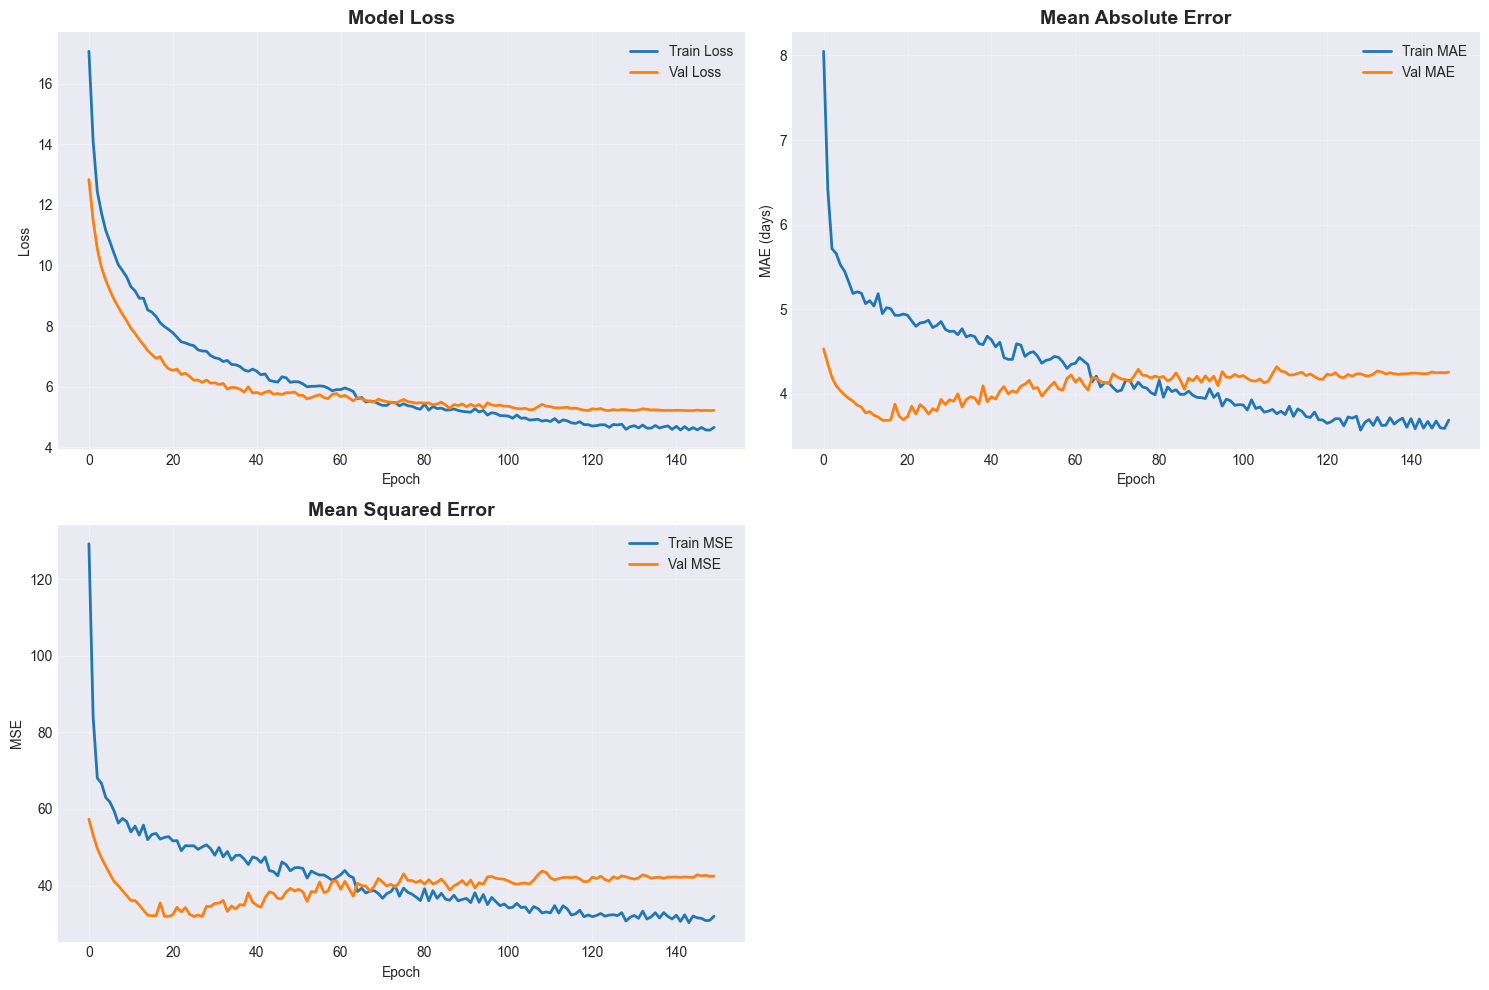

✅ Predictions plot saved: predictions.png


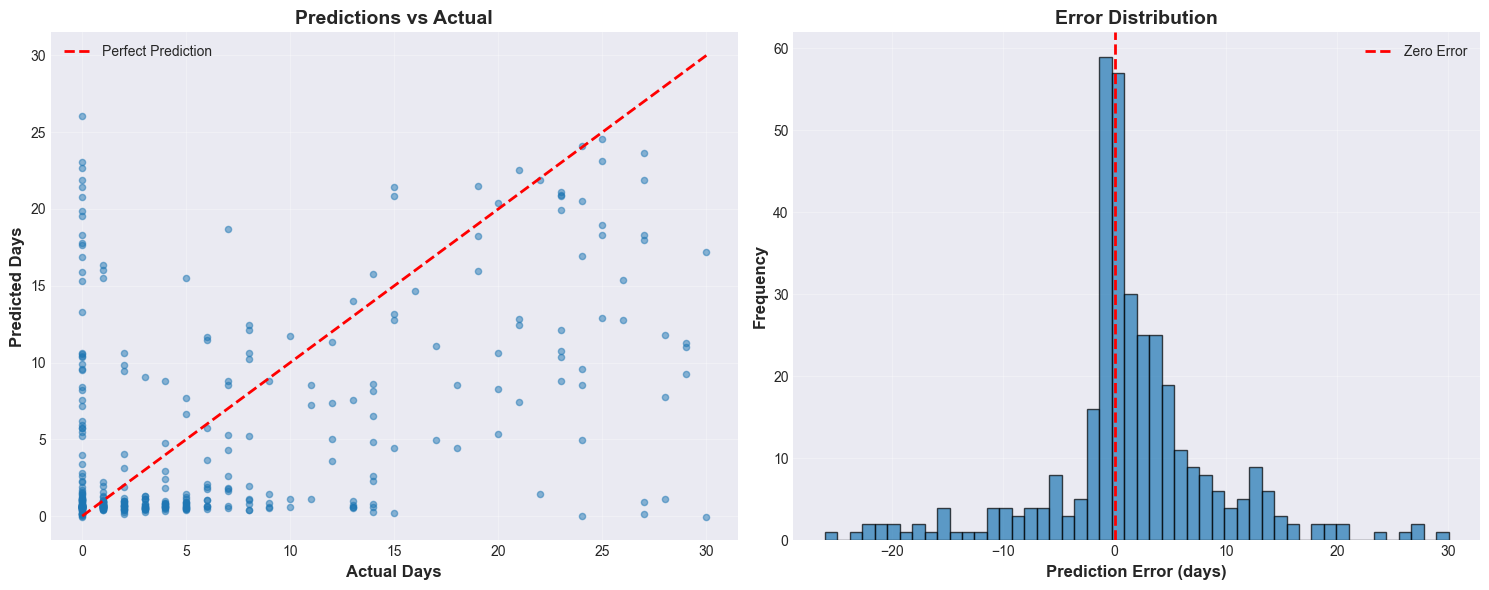

⚠️  Step 10: Create visualizations


In [31]:
# Step 10: Visualize
plot_training_history(history, save_path='training_history.png')
plot_predictions(data['y_test'], results['predictions'], save_path='predictions.png')
print("⚠️  Step 10: Create visualizations")


## 🔮 Quick Inference Example

In [ ]:
"""
QUICK INFERENCE EXAMPLE

Use this to load a saved model and make predictions
"""

# Load the latest saved model
model_components = load_complete_model()

# Make predictions on new data
predictions = predict_new_data(model_components, new_df)

print(f"Predictions: {predictions}")

print("\n✅ Inference example ready!")
print("\nUncomment to load model and make predictions.")

## 📋 Summary

### Your Current Performance (Excellent! 🎉)
- **MAE: 3.59 days** (Much better than baseline 6.17 days)
- **Within 7 days: 91.9%** (Outstanding!)
- **Within 14 days: 96.3%** (Excellent precision)

### What This Notebook Provides

1. **Enhanced Architecture**
   - Bidirectional LSTM (128 → 64 units)
   - Batch normalization
   - L1/L2 regularization
   - Dropout for regularization

2. **Comprehensive Model Saving**
   - ✅ Full model (.h5)
   - ✅ SavedModel format (TensorFlow)
   - ✅ Weights only
   - ✅ Architecture (JSON)
   - ✅ Training history
   - ✅ Metadata
   - ✅ Scaler
   - ✅ Feature names

3. **Training Features**
   - Early stopping
   - Learning rate reduction
   - Model checkpointing
   - CSV logging
   - TensorBoard support

4. **Easy Inference**
   - Simple model loading
   - Prediction on new data
   - All preprocessing handled automatically

### Next Steps

1. Load your data
2. Run the pipeline
3. Model will be saved automatically
4. Use `load_complete_model()` for inference
5. Share the `models/` directory for deployment

**Your model is already performing excellently! This notebook helps you save and deploy it properly.** 🚀